# **Load the relevant packages**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.tree import ExtraTreeRegressor

from sklearn.metrics import mean_squared_error
from scipy import stats

# **Extra Trees Regression**

In [2]:
# This is the preprocessed data
X = np.load('/content/drive/MyDrive/FragmentIntensity/X_final.npy')
y = np.load('/content/drive/MyDrive/FragmentIntensity/y_final.npy')

In [3]:
# split the data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [4]:
# These parameters are based on the hyperparameter tuning results
et_regressor = ExtraTreeRegressor(max_depth=13, min_samples_split=3)
et_regressor.fit(X_train, y_train)

ExtraTreeRegressor(max_depth=13, min_samples_split=3)

In [5]:
# This function normalises the predictions to scale between 0 and 1
def normalize_predictions(preds, test):
    norms = []

    #max-scale intensities
    for arr in preds:
        max_intensity = np.max(arr)
        normalized_arr = arr / max_intensity
        norms.append(normalized_arr)

    norms = np.array(norms) # convert to numpy-array

    fix = []

    # make sure that -1 values in prediction match -1 values in test
    for y_pred_arr, y_test_arr in zip(norms, test):
        fixed_arr = np.where((y_test_arr == -1), -1, y_pred_arr)
        fix.append(fixed_arr)

    fix = np.array(fix)

    p_fil = []
    t_fil = []

    # remove -1 values to not falsely boost accuracy scores
    for y_pred_arr, y_test_arr in zip(fix, test):
        mask = (y_pred_arr != -1)
        filtered_y_pred_arr = y_pred_arr[mask]
        filtered_y_test_arr = y_test_arr[mask]
        p_fil.append(filtered_y_pred_arr)
        t_fil.append(filtered_y_test_arr)

    t_fil = np.concatenate(t_fil)
    p_fil = np.concatenate(p_fil)
    return [p_fil, t_fil]

In [6]:
# The normalised dot product as a scoring metric
def norm_dot_product(v1, v2):
  dot_product = np.dot(v1,v2)

  norm1 = np.linalg.norm(v1)
  norm2 = np.linalg.norm(v2)

  return dot_product/(norm1 * norm2)

In [7]:
# Normalising the predictions
y_pred = et_regressor.predict(X_test)
a,b = normalize_predictions(y_pred, y_test)

In [8]:
# The mean squared error
mean_squared_error(a,b)

0.06759180217888085

In [9]:
# The normalised dot product
norm_dot_product(a,b)

0.7412217340579565

In [10]:
# The Pearson's R
stats.pearsonr(a,b)

PearsonRResult(statistic=0.6120159311838783, pvalue=0.0)

# **Cross Validation**

In [12]:
mse_scores = []
pearson_r_scores = []
norm_dot_product_scores = []

kf = KFold(n_splits=5, shuffle=False)
X_80 = X_train
y_80 = y_train

for train_index, test_index in kf.split(X_80):
    X_train, X_test = X_80[train_index], X_80[test_index]
    y_train, y_test = y_80[train_index], y_80[test_index]

    et_regressor = ExtraTreeRegressor(max_depth = 13, min_samples_split = 3)
    et_regressor.fit(X_train, y_train)
    y_pred = et_regressor.predict(X_test)
    a,b = normalize_predictions(y_pred, y_test)

    mse = mean_squared_error(b, a)
    mse_scores.append(mse)

    pearson_r, _ = stats.pearsonr(b, a)
    pearson_r_scores.append(pearson_r)

    ndp = norm_dot_product(b, a)
    norm_dot_product_scores.append(ndp)

# print metrics for each fold
for i in range(5):
    print(f"Fold {i + 1}:")
    print("MSE:", mse_scores[i])
    print("Pearson's R:", pearson_r_scores[i])
    print("norm_dot_product:", norm_dot_product_scores[i])
    print()

# calculate and print mean metrics
mean_mse = np.mean(mse_scores)
mean_pearson_r = np.mean(pearson_r_scores)
mean_norm_dot_product = np.mean(norm_dot_product_scores)

print("Mean MSE:", mean_mse)
print("Mean Pearson's R:", mean_pearson_r)
print("Mean norm_dot_product:", mean_norm_dot_product)

Fold 1:
MSE: 0.06936586926159272
Pearson's R: 0.6075868198710341
norm_dot_product: 0.7388468935886894

Fold 2:
MSE: 0.06909309562076203
Pearson's R: 0.6046165552056191
norm_dot_product: 0.7368664982831704

Fold 3:
MSE: 0.07092505380643
Pearson's R: 0.6020875573633822
norm_dot_product: 0.7356501537348163

Fold 4:
MSE: 0.06999352946948233
Pearson's R: 0.6027296357523133
norm_dot_product: 0.7355514483191453

Fold 5:
MSE: 0.07198453971912111
Pearson's R: 0.5977796572856768
norm_dot_product: 0.7328880666191735

Mean MSE: 0.07027241757547764
Mean Pearson's R: 0.6029600450956052
Mean norm_dot_product: 0.7359606121089989


# **Hyperparameter Tuning**

*Note: as the parameter 'n_estimators' cannot be used in Grid Search Cross Validation, this code can be repeated with different values for this parameter.*

In [ ]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

search_params = {
    'max_depth' : [9, 12, 13, 14, 15, 16],
    'min_samples_split': [2, 3, 4, 5],
}

# Valid parameters are: ['ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes',
# 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'random_state', 'splitter'].

In [ ]:
grid_search = GridSearchCV(
    estimator = et_regressor(),
    param_grid = search_params,
    scoring = ['r2'],
    refit = 'r2',
    cv = 5,
    verbose = 4)

In [ ]:
grid_search.fit(X_train, y_train)

In [ ]:
# Get the complete details of the best model
print(grid_search.best_estimator_)

In [ ]:
# Get the best score according to the metric passed above
print(grid_search.best_score_)

In [ ]:
# Make a data frame of the results
df = pd.DataFrame(grid_search.cv_results_)
df = df.sort_values('rank_test_r2')
df.to_csv('grid_search_results.csv')

# **Heatmap of the hyperparameter tuning results**

In [ ]:
df = pd.read_csv('grid_search_results.csv')

In [ ]:
df.head()

Unnamed: 0  mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0           9      36.649508      1.380231         0.854309        0.146641   
1           6      35.767720      1.038034         0.764982        0.046280   
2           8      36.494549      0.652497         0.829983        0.057317   
3          10      37.127083      1.198833         0.808935        0.089071   
4          11      38.621391      1.112145         0.868246        0.123490   

   param_max_depth  param_min_samples_split  \
0               13                        3   
1               12                        4   
2               13                        2   
3               13                        4   
4               13                        5   

                                      params  split0_test_r2  split1_test_r2  \
0  {'max_depth': 13, 'min_samples_split': 3}        0.772740        0.776013   
1  {'max_depth': 12, 'min_samples_split': 4}        0.771288        0.770458   
2  {'max_depth': 13, 'min_samples_split': 2}        0.770154        0.771762   
3  {'max_depth': 13, 'min_samples_split': 4}        0.766372        0.767474   
4  {'max_depth': 13, 'min_samples_split': 5}        0.770448        0.761677   

   split2_test_r2  split3_test_r2  split4_test_r2  mean_test_r2  std_test_r2  \
0        0.768587        0.773829        0.766351      0.771504     0.003530   
1        0.775021        0.773332        0.766159      0.771252     0.003004   
2        0.767897        0.771687        0.773906      0.771081     0.001990   
3        0.771581        0.774491        0.769008      0.769785     0.002931   
4        0.770530        0.774230        0.770648      0.769507     0.004168   

   rank_test_r2  
0             1  
1             2  
2             3  
3             4  
4             5

In [ ]:
# Adjust the data frame to only include relevant columns
df = df.sort_values(by='mean_test_r2', ascending=False)
selected_columns = ['param_max_depth', 'param_min_samples_split', 'mean_test_r2']
df = df[selected_columns].reset_index()

column_mapping = {'param_max_depth': 'Max. tree depth', 'param_min_samples_split': 'Min. split samples', 'mean_test_r2': 'R-squared value'}

# Use the rename method to rename columns
df.rename(columns=column_mapping, inplace=True)

In [ ]:
df.head()

index  Max. tree depth  Min. split samples  R-squared value
0      0               13                   3         0.771504
1      1               12                   4         0.771252
2      2               13                   2         0.771081
3      3               13                   4         0.769785
4      4               13                   5         0.769507

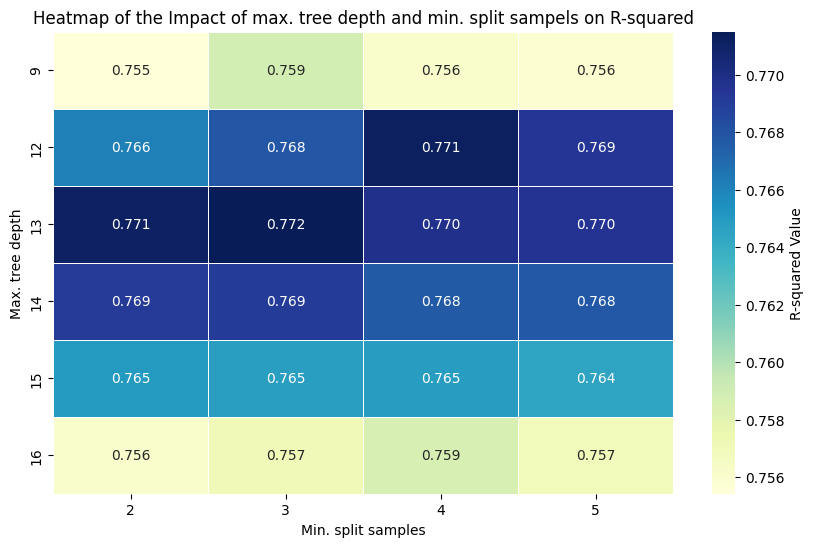

In [ ]:
import seaborn as sns

# index as the variable that has the most impact
pivot_table = df.pivot_table(values='R-squared value', index='Max. tree depth', columns='Min. split samples', aggfunc='mean')

# heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, cmap="YlGnBu", annot=True, fmt='.3f', linewidths=.5)
cax = plt.gcf().axes[-1]
cax.set_ylabel("R-squared Value")
plt.title("Heatmap of the Impact of max. tree depth and min. split sampels on R-squared")
plt.show()